In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import urllib
import re
from io import StringIO
import gzip
from ftplib import FTP
import random
import math
import copy
import pickle as pkl

from toolbox import *

%matplotlib inline
sns.set()

In [2]:
sns.set(rc={'figure.figsize':(14,6)})

In [3]:
cfg = load_cfg()

logVersions = load_LogVersions()

# Load data

## IntAct

**Using only interactions with scores above a certain threshold (filtered)**

In [5]:
intact = pd.read_pickle(
    os.path.join(cfg['outputPreprocessingIntAct'], 
                 "intact_yeast_allScores_v{}.pkl".format(logVersions['IntAct']['preprocessed']['yeast'])
                )
)
glance(intact)

DataFrame: 43,068 rows 	 3 columns


,uniprotID_A,uniprotID_B,intact-miscore
0,P04050,P38827,0.22
1,P15019,P53228,0.22
2,P46970,Q03214,0.27
3,P17558,P38972,0.27
4,P53173,Q12234,0.27


In [6]:
allIDs_intact = pd.concat([intact.uniprotID_A,intact.uniprotID_B])

## UniProt

In [7]:
uniprotIDs = pd.read_csv(
        os.path.join(cfg['rawDataUniProt'], 
                     "uniprot_allProteins_yeast_v{}.pkl".format(logVersions['UniProt']['yeast']['rawData'])),
        header=None,
        names=['uniprotID']
    )
glance(uniprotIDs)

DataFrame: 6,721 rows 	 1 columns


,uniprotID
0,A0A023PXA5
1,A0A023PXB0
2,A0A023PXB5
3,A0A023PXB9
4,A0A023PXC2


## Hubs

In [8]:
path0 = os.path.join(
    cfg['outputPreprocessingIntAct'], 
    "listHubs_yeast_20p_v{}.pkl".format(logVersions['IntAct']['preprocessed']['yeast'])
)

with open(path0, 'rb') as f:
    list_hubs20 = pkl.load(f)

glance(list_hubs20)

list: len 1195
['P11484', 'P10591', 'P32589', 'P10592', 'P40150']


# EDA

In [9]:
foo = set(allIDs_intact)

baar = len(uniprotIDs)

print(f"Number of interactions: {len(intact):,}")
print("Number of unique proteins: {:,} / {:,} ({:.2%})".format(len(foo), baar, len(foo)/baar))

Number of interactions: 43,068
Number of unique proteins: 5,679 / 6,721 (84.50%)


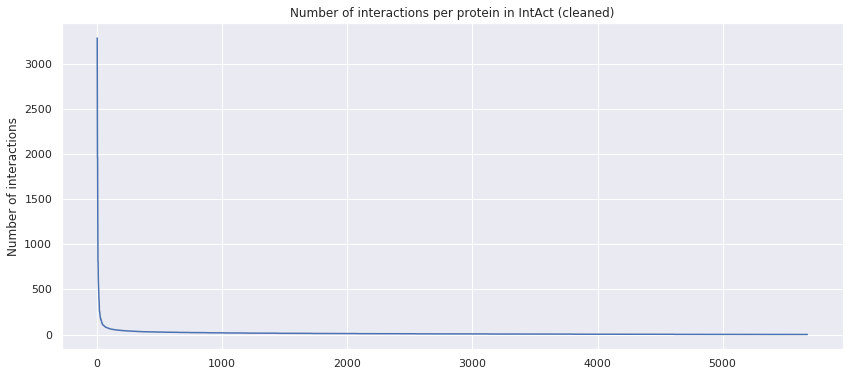

In [10]:
valCounts = allIDs_intact.value_counts()

plt.plot(range(len(valCounts)), valCounts.values)
plt.xlabel('')
plt.ylabel('Number of interactions')
plt.title('Number of interactions per protein in IntAct (cleaned)');

In [11]:
def EDA_interactionsPerProtein(df, list_hubs, onlyHub=False):
    
    listID = pd.concat([intact.uniprotID_A,intact.uniprotID_B])
    
    if not onlyHub:
        print("-- Percentiles of number of interactions per protein:")
        foo = list(np.linspace(0.1,0.9,9))+list(np.linspace(0.91,0.99,9))
        print(listID.value_counts().describe(percentiles = foo))
        print()

        print("-- Bigger hubs:")
        print(listID.value_counts()[:10])
        print()

        print(f'-- Official list of hubs: {len(list_hubs):,} proteins')
        print()

    bar = df.loc[df.uniprotID_A.isin(list_hubs)|df.uniprotID_B.isin(list_hubs)]
    print(f"Contribution of the hubs (at least one protein): {len(bar):,} interactions out of {len(df):,} ({len(bar)/len(df):.2%})")
    baar = df.loc[df.uniprotID_A.isin(list_hubs)&df.uniprotID_B.isin(list_hubs)]
    print(f"... both proteins: {len(baar):,} interactions out of {len(df):,} ({len(baar)/len(df):.2%})")
    print(f"... and {len(df)-len(bar):,} interactions with no hubs at all")
    print()
    

In [12]:
EDA_interactionsPerProtein(df=intact, list_hubs=list_hubs20)

-- Percentiles of number of interactions per protein:
count    5679.000000
mean       15.167459
std        75.410818
min         1.000000
10%         1.000000
20%         3.000000
30%         4.000000
40%         6.000000
50%         7.000000
60%        10.000000
70%        13.000000
80%        17.000000
90%        26.000000
91%        28.000000
92%        29.000000
93%        31.000000
94%        33.000000
95%        37.000000
96%        42.000000
97%        49.000000
98%        60.000000
99%        95.220000
max      3285.000000
dtype: float64

-- Bigger hubs:
P11484    3285
P10591    2524
P32589    1959
P10592    1957
P40150    1243
P02829    1120
P25491     804
P33416     803
P38788     676
Q02159     604
dtype: int64

-- Official list of hubs: 1,195 proteins

Contribution of the hubs (at least one protein): 40,177 interactions out of 43,068 (93.29%)
... both proteins: 17,452 interactions out of 43,068 (40.52%)
... and 2,891 interactions with no hubs at all



# Create positive set

In [13]:
seed_GS = 908

**List of proteins in the positive set**

In [14]:
proteinList = sorted(list(set(allIDs_intact)))
glance(proteinList)

list: len 5679
['A0A023PXA5', 'A0A023PXH6', 'A0A023PXI0', 'A0A023PXP4', 'A0A023PYF7']


In [15]:
PPI = intact[['uniprotID_A','uniprotID_B']].copy()

PPI['isInteraction'] = 1

glance(PPI)

DataFrame: 43,068 rows 	 3 columns


,uniprotID_A,uniprotID_B,isInteraction
0,P04050,P38827,1
1,P15019,P53228,1
2,P46970,Q03214,1
3,P17558,P38972,1
4,P53173,Q12234,1


---
**EDA**

In [16]:
EDA_predSet(
    PPI,
    list_hubs=list_hubs20,
    PosNeg=False,
    trainSet=None,
    Overlap=False
)

43,068 interactions (100.00% positive)

Hub status:
- 17,452 hub-hub interactions (40.52% - 100.00% positive)
- 22,725 hub-lone interactions (52.77% - 100.00% positive)
- 2,891 lone-lone interactions (6.71% - 100.00% positive)



## Split positive train/test

In [17]:
PPI2 = PPI.copy()

----
**Sample proteins to save for test**

In [18]:
hubsHere = sorted(list(set(list_hubs20) & set(proteinList)))
nonHubsHere = sorted(list(set(proteinList) - set(list_hubs20)))

print(f"In this PPI set, we have {len(hubsHere):,} hubs and {len(nonHubsHere):,} non-hubs ({len(proteinList):,} total)")
assert len(proteinList) == len(hubsHere)+len(nonHubsHere)

In this PPI set, we have 1,195 hubs and 4,484 non-hubs (5,679 total)


In [19]:
random.seed(seed_GS)

testProteins_rate = 0.13

test_hubs = random.sample(hubsHere, int(testProteins_rate*len(hubsHere)))
test_nonHubs = random.sample(nonHubsHere, int(testProteins_rate*len(nonHubsHere)))
test_proteins = test_hubs + test_nonHubs
glance(test_proteins)

list: len 737
['P10081', 'P53236', 'P33759', 'P12753', 'P40512']


In [20]:
print(f"Total set of proteins: {len(proteinList):,}")
print(f"... {len(test_proteins):,} for no/partial overlap ({len(test_proteins)/len(proteinList):.2%})")

Total set of proteins: 5,679
... 737 for no/partial overlap (12.98%)


---
**Set aside `test` PPIs**

In [21]:
PPI2['trainTest'] = ''

glance(PPI2)

DataFrame: 43,068 rows 	 4 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest
0,P04050,P38827,1,
1,P15019,P53228,1,
2,P46970,Q03214,1,
3,P17558,P38972,1,
4,P53173,Q12234,1,


In [22]:
AisTestProt = PPI2.uniprotID_A.isin(test_proteins).astype(int)
BisTestProt = PPI2.uniprotID_B.isin(test_proteins).astype(int)
testProtType = AisTestProt + BisTestProt

print(testProtType.value_counts())

0    33743
1     8763
2      562
dtype: int64


In [23]:
PPI2.loc[testProtType >= 1, 'trainTest'] = 'test'

print(PPI2.trainTest.value_counts())

        33743
test     9325
Name: trainTest, dtype: int64


---
**Set aside interactions for complete overlap**

In [24]:
random.seed(seed_GS + 10)
CO_rate = 0.1

foo = PPI2.loc[PPI2.trainTest == '']

testCO = random.sample(list(foo.index), int(CO_rate*len(foo)))

glance(testCO)

list: len 3374
[38015, 7251, 12147, 30523, 1227]


In [25]:
PPI2.loc[testCO,'trainTest'] = 'test'

print(PPI2.trainTest.value_counts())

        30369
test    12699
Name: trainTest, dtype: int64


---
**EDA**

In [26]:
foo = PPI2.trainTest.value_counts()
for x in ['','test']:
    if x == '':
        x2 = 'train'
    else:
        x2=x
    print(f"{x2}: {foo[x]:,} PPIs ({foo[x]/len(PPI2):.2%})")

train: 30,369 PPIs (70.51%)
test: 12,699 PPIs (29.49%)


In [27]:
print('## Train set')
EDA_predSet(
    PPI2.loc[PPI2.trainTest == ''],
    list_hubs=list_hubs20,
    trainSet = PPI2.loc[PPI2.trainTest == ''],
    PosNeg=False,
    Overlap=False
)


## Train set
30,369 interactions (100.00% positive)

Hub status:
- 12,106 hub-hub interactions (39.86% - 100.00% positive)
- 16,292 hub-lone interactions (53.65% - 100.00% positive)
- 1,971 lone-lone interactions (6.49% - 100.00% positive)



In [28]:
print('## Test set')
EDA_predSet(
    PPI2.loc[PPI2.trainTest == 'test'],
    list_hubs=list_hubs20,
    trainSet = PPI2.loc[PPI2.trainTest == ''],
    PosNeg=False,
#     Overlap=False
)


## Test set
12,699 interactions (100.00% positive)

Hub status:
- 5,346 hub-hub interactions (42.10% - 100.00% positive)
- 6,433 hub-lone interactions (50.66% - 100.00% positive)
- 920 lone-lone interactions (7.24% - 100.00% positive)

Overlap with train:
- 3,306 total overlap with train, both proteins already seen (26.03% - 100.00% positive)
- 8,774 partial overal, only one protein seen (69.09% - 100.00% positive)
- 619 no overlap (4.87% - 100.00% positive)

### Hub-Hub only ###

Overlap with train:
- 1,347 total overlap with train, both proteins already seen (25.20% - 100.00% positive)
- 3,743 partial overal, only one protein seen (70.01% - 100.00% positive)
- 256 no overlap (4.79% - 100.00% positive)

### Hub-Lone only ###

Overlap with train:
- 1,763 total overlap with train, both proteins already seen (27.41% - 100.00% positive)
- 4,378 partial overal, only one protein seen (68.06% - 100.00% positive)
- 292 no overlap (4.54% - 100.00% positive)

### Lone-Lone only ###

Overlap wit

In [29]:
PPI3 = PPI2.copy()

---
**Allocate `train`**

In [34]:
PPI3.loc[PPI3.trainTest == '','trainTest'] = 'train'

In [35]:
foo = PPI3.trainTest.value_counts()
for x in ['train','test']:
    print(f"{x}: {foo[x]:,} PPIs ({foo[x]/len(PPI3):.2%})")

train: 30,369 PPIs (70.51%)
test: 12,699 PPIs (29.49%)


In [36]:
PPI3.trainTest.value_counts()['train']

30369

# Sample NIPs

In [37]:
PPI_final = PPI3.copy()
glance(PPI_final)

DataFrame: 43,068 rows 	 4 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest
0,P04050,P38827,1,test
1,P15019,P53228,1,train
2,P46970,Q03214,1,train
3,P17558,P38972,1,train
4,P53173,Q12234,1,train


## `train`

- Weighted sampling 
- 50% positive

In [38]:
PPI_train = PPI_final.loc[PPI_final.trainTest == 'train']
allIDs_PPI_train = pd.concat([PPI_train.uniprotID_A,PPI_train.uniprotID_B])

NIPs_train = sampleNIPs(
    IDs2sample=allIDs_PPI_train.to_list(), 
    seed=seed_GS+30, 
    targetSampleSize=len(PPI_train), 
    referenceIntAct=intact
)

NIPs_train['isInteraction'] = 0
NIPs_train['trainTest'] = 'train'

Removed 248 self-interactions
Removed 6,272 duplicates
Removed 5,039 known false negatives
Final number of interactions: 30,369


In [39]:
glance(NIPs_train)

DataFrame: 30,369 rows 	 4 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest
0,P38882,P53874,0,train
2,P50089,Q05791,0,train
3,P25491,Q06708,0,train
4,P33322,P33413,0,train
5,P11709,Q04659,0,train


In [40]:
EDA_predSet(
    NIPs_train,
    list_hubs=list_hubs20,
    PosNeg=False,
    trainSet=None,
    Overlap=False
)

30,369 interactions (0.00% positive)

Hub status:
- 10,562 hub-hub interactions (34.78% - 0.00% positive)
- 15,356 hub-lone interactions (50.56% - 0.00% positive)
- 4,451 lone-lone interactions (14.66% - 0.00% positive)



## `test`

- uniform sampling 
- 50% positive (which is harder than it seems to keep 50% positive in each category!)

In [41]:
PPI_test = PPI_final.loc[PPI_final.trainTest == 'test']

glance(PPI_test)
glance(test_proteins)

DataFrame: 12,699 rows 	 4 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest
0,P04050,P38827,1,test
7,P04911,Q06266,1,test
9,P47054,Q06625,1,test
10,P32528,P32571,1,test
12,P39015,P40522,1,test


list: len 737
['P10081', 'P53236', 'P33759', 'P12753', 'P40512']


In [42]:
_, _, isInTrain = find_overlapStatus(
    df = PPI_test, 
    trainSet = PPI_train
)

isInTrain.value_counts()

1    8774
2    3306
0     619
dtype: int64

In [43]:
NIPs_temp = NIPs_train.copy()

# No overlap
NIPs_test_no = sampleNIPs(
    IDs2sample=test_proteins, 
    seed=seed_GS+50, 
    targetSampleSize=isInTrain.value_counts()[0], 
    referenceIntAct=intact,
    otherRefDf=NIPs_temp[['uniprotID_A','uniprotID_B']]
)
NIPs_test_no['isInteraction'] = 0
NIPs_test_no['trainTest'] = 'test'
NIPs_temp = NIPs_temp.append(NIPs_test_no)
NIPs_test = NIPs_test_no
print()

# Complete overlap
NIPs_test_co = sampleNIPs(
    IDs2sample=sorted(list(set(allIDs_PPI_train))), 
    seed=seed_GS+60, 
    targetSampleSize=isInTrain.value_counts()[2], 
    referenceIntAct=intact,
    otherRefDf=NIPs_temp[['uniprotID_A','uniprotID_B']]
)
NIPs_test_co['isInteraction'] = 0
NIPs_test_co['trainTest'] = 'test'
NIPs_temp = NIPs_temp.append(NIPs_test_co)
NIPs_test = NIPs_test.append(NIPs_test_co)
print()

# Partial overlap
NIPs_test_po = sampleNIPs(
    IDs2sample=(
        test_proteins,
        sorted(list(set(allIDs_PPI_train)))
    ), 
    seed=seed_GS+70, 
    targetSampleSize=isInTrain.value_counts()[1], 
    referenceIntAct=intact,
    otherRefDf=NIPs_temp[['uniprotID_A','uniprotID_B']]
)
NIPs_test_po['isInteraction'] = 0
NIPs_test_po['trainTest'] = 'test'
NIPs_temp = NIPs_temp.append(NIPs_test_po)
NIPs_test = NIPs_test.append(NIPs_test_po)

Removed 0 self-interactions
Removed 1 duplicates
Removed 0 known false negatives
Removed 0 based on other ref dataset
Final number of interactions: 619

Removed 0 self-interactions
Removed 1 duplicates
Removed 10 known false negatives
Removed 6 based on other ref dataset
Final number of interactions: 3,306

Removed 0 self-interactions
Removed 25 duplicates
Removed 34 known false negatives
Removed 0 based on other ref dataset
Final number of interactions: 8,774


In [44]:
glance(NIPs_test)

DataFrame: 12,699 rows 	 4 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest
0,P34243,Q12103,0,test
1,P38215,Q05788,0,test
2,P47166,Q12288,0,test
3,P33759,P39958,0,test
4,P16550,Q02831,0,test


In [45]:
## Sanity checks

assert len(NIPs_test.loc[NIPs_test.duplicated(subset=['uniprotID_A','uniprotID_B'], keep=False)]) == 0

# Aggregate GS

In [46]:
# GS = PPI_final.append(NIPs_train).append(NIPs_test1)
GS = PPI_final.append(NIPs_train).append(NIPs_test)

glance(GS)

DataFrame: 86,136 rows 	 4 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest
0,P04050,P38827,1,test
1,P15019,P53228,1,train
2,P46970,Q03214,1,train
3,P17558,P38972,1,train
4,P53173,Q12234,1,train


In [47]:
GS.tail()

,uniprotID_A,uniprotID_B,isInteraction,trainTest
8769,P12687,P34233,0,test
8770,P39526,P47042,0,test
8771,P25659,P48231,0,test
8772,P40043,Q07790,0,test
8773,P40433,P53887,0,test


In [48]:
## Sanity checks

assert len(GS.loc[GS.duplicated(subset=['uniprotID_A','uniprotID_B'], keep=False)]) == 0

---
**EDA**

In [49]:
print('## Train\n')
EDA_predSet(
    GS.loc[GS.trainTest == 'train'],
    list_hubs=list_hubs20,
    trainSet = GS.loc[GS.trainTest == 'train'],
    Overlap=False
)

## Train

60,738 interactions (50.00% positive)

Hub status:
- 22,668 hub-hub interactions (37.32% - 53.41% positive)
- 31,648 hub-lone interactions (52.11% - 51.48% positive)
- 6,422 lone-lone interactions (10.57% - 30.69% positive)

### Positive only ###

Hub status:
- 12,106 hub-hub interactions (39.86% - 100.00% positive)
- 16,292 hub-lone interactions (53.65% - 100.00% positive)
- 1,971 lone-lone interactions (6.49% - 100.00% positive)

### Negative only ###

Hub status:
- 10,562 hub-hub interactions (34.78% - 0.00% positive)
- 15,356 hub-lone interactions (50.56% - 0.00% positive)
- 4,451 lone-lone interactions (14.66% - 0.00% positive)



In [50]:
print('## Test\n')

EDA_predSet(
    GS.loc[GS.trainTest == 'test'],
    list_hubs=list_hubs20,
    trainSet = GS.loc[GS.trainTest == 'train'],
)

## Test

25,398 interactions (50.00% positive)

Hub status:
- 5,937 hub-hub interactions (23.38% - 90.05% positive)
- 10,716 hub-lone interactions (42.19% - 60.03% positive)
- 8,745 lone-lone interactions (34.43% - 10.52% positive)

Overlap with train:
- 6,612 total overlap with train, both proteins already seen (26.03% - 50.00% positive)
- 17,548 partial overal, only one protein seen (69.09% - 50.00% positive)
- 1,238 no overlap (4.87% - 50.00% positive)

### Positive only ###

Hub status:
- 5,346 hub-hub interactions (42.10% - 100.00% positive)
- 6,433 hub-lone interactions (50.66% - 100.00% positive)
- 920 lone-lone interactions (7.24% - 100.00% positive)

Overlap with train:
- 3,306 total overlap with train, both proteins already seen (26.03% - 100.00% positive)
- 8,774 partial overal, only one protein seen (69.09% - 100.00% positive)
- 619 no overlap (4.87% - 100.00% positive)

### Negative only ###

Hub status:
- 591 hub-hub interactions (4.65% - 0.00% positive)
- 4,283 hub-lone 

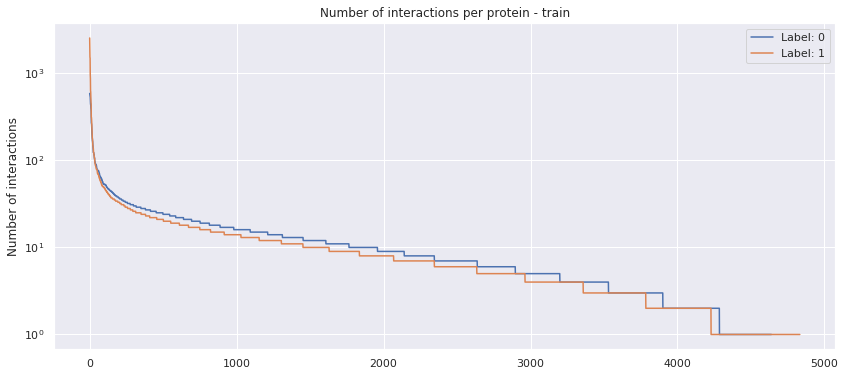

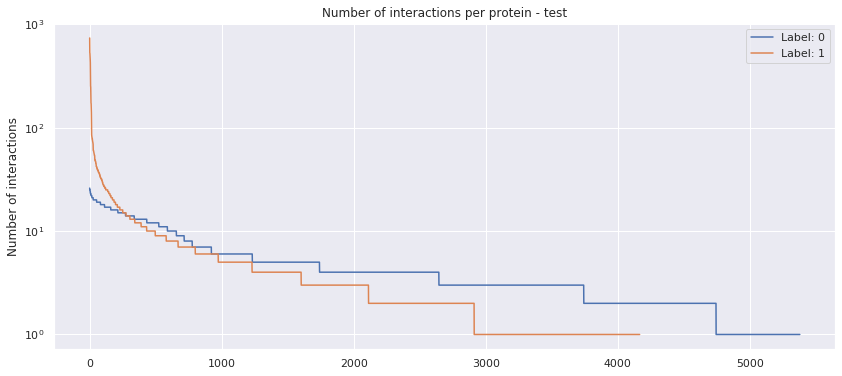

In [51]:
for x in ['train','test']:
    for y in [0,1]:
        foo = GS.loc[(GS.isInteraction == y)&(GS.trainTest == x)]
        allIDs = pd.concat([foo.uniprotID_A, foo.uniprotID_B])
        valCounts = allIDs.value_counts()
        plt.plot(
            range(len(valCounts)), valCounts.values, 
            label=f"Label: {y}"
        )
    plt.xlabel('')
    plt.ylabel('Number of interactions')
    plt.title(f'Number of interactions per protein - {x}')
    plt.yscale('log')
    plt.legend()
    plt.show();

In [52]:
GS.trainTest.value_counts()

train    60738
test     25398
Name: trainTest, dtype: int64

## Add Similarity Measures

In [53]:
def AddSimilarityMeasures(df, cfg, logVersions, df_path=None):
    
    if df_path is None:
        path2use = f"similarityMeasures_v{logVersions['featuresEngineering']['similarityMeasure']}.pkl"
    else:
        path2use = df_path
    
    df_features = pd.read_pickle(
        os.path.join(
            cfg['outputFeaturesEngineering'],
            path2use
        )
    )
    df_features['isThere'] = 1
    assert ~df_features.duplicated(subset=["uniprotID_A","uniprotID_B"]).any()
    
    foo = df.merge(
        df_features,
        how = 'left',
        on = ["uniprotID_A","uniprotID_B"]
    )
    
    assert len(foo) == len(df)  
    assert foo.isThere.isna().sum() == 0
    assert ~foo.duplicated(subset=["uniprotID_A","uniprotID_B"]).any()
    
    foo.drop(['isThere'], axis=1, inplace=True)
    
    return foo

In [54]:
to_enrich = GS

In [55]:
GS_SM = AddSimilarityMeasures(
    to_enrich, cfg=cfg, logVersions=logVersions,
    df_path = f"similarityMeasures_yeast_v{logVersions['featuresEngineering']['yeast']['similarityMeasure']}.pkl"
)
glance(GS_SM)

print("success")

DataFrame: 86,136 rows 	 9 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest,bioProcessUniprot,cellCompUniprot,molFuncUniprot,domainUniprot,motifUniprot
0,P04050,P38827,1,test,0.000000,0.000000,0.0,0.0,0.0
1,P15019,P53228,1,train,0.666667,1.000000,1.0,0.0,0.0
2,P46970,Q03214,1,train,0.000000,0.516398,0.0,0.0,0.0
3,P17558,P38972,1,train,0.000000,0.000000,0.0,0.0,0.0
4,P53173,Q12234,1,train,0.316228,0.235702,0.0,0.0,0.0


success


In [56]:
GS_SM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86136 entries, 0 to 86135
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   uniprotID_A        86136 non-null  object 
 1   uniprotID_B        86136 non-null  object 
 2   isInteraction      86136 non-null  int64  
 3   trainTest          86136 non-null  object 
 4   bioProcessUniprot  86136 non-null  float64
 5   cellCompUniprot    86136 non-null  float64
 6   molFuncUniprot     86136 non-null  float64
 7   domainUniprot      86136 non-null  float64
 8   motifUniprot       86136 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 6.6+ MB


## Add sequence

In [57]:
glance(GS_SM)

DataFrame: 86,136 rows 	 9 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest,bioProcessUniprot,cellCompUniprot,molFuncUniprot,domainUniprot,motifUniprot
0,P04050,P38827,1,test,0.000000,0.000000,0.0,0.0,0.0
1,P15019,P53228,1,train,0.666667,1.000000,1.0,0.0,0.0
2,P46970,Q03214,1,train,0.000000,0.516398,0.0,0.0,0.0
3,P17558,P38972,1,train,0.000000,0.000000,0.0,0.0,0.0
4,P53173,Q12234,1,train,0.316228,0.235702,0.0,0.0,0.0


In [58]:
sequenceData = pd.read_pickle(
    os.path.join(
        cfg['outputPreprocessingUniprot'], 
        "sequenceData_yeast_v{}--{}.pkl".format(logVersions['UniProt']['yeast']['rawData'], logVersions['UniProt']['yeast']['preprocessed'])
    )
)

glance(sequenceData)

DataFrame: 6,721 rows 	 2 columns


,uniprotID,sequence
0,A0A023PXA5,MLLSELVATASSLPYTAISIHNNCRVPAARHIHHGCRYFHGPPVMH...
1,A0A023PXB0,MFINGFVNYPVRTPPNDLLQVVLHGFLRCPLDGSQVDSIGIGHTVH...
2,A0A023PXB5,MFALIISSKGKTSGFFFNSSFSSSALVGIAPLTAYSALVTPVFKSF...
3,A0A023PXB9,MEYVLIYNIWFFSFLQDKPCFCFVDYACSIFLLSSYCGNCLTAVAT...
4,A0A023PXC2,MLPLCLTFLSFFLSLGGSFKAVMTKEEADGTTEAAACLFWIFNWTV...


In [59]:
sequenceData.columns = ['uniprotID_A', 'sequence_A']
GS_SM_seq = GS_SM.merge(
    sequenceData,
    how = 'left',
    on = "uniprotID_A"
)

sequenceData.columns = ['uniprotID_B', 'sequence_B']
GS_SM_seq = GS_SM_seq.merge(
    sequenceData,
    how = 'left',
    on = "uniprotID_B"
)

glance(GS_SM_seq)

assert GS_SM_seq.isna().sum()['sequence_A'] + GS_SM_seq.isna().sum()['sequence_B'] == 0

DataFrame: 86,136 rows 	 11 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest,bioProcessUniprot,cellCompUniprot,molFuncUniprot,domainUniprot,motifUniprot,sequence_A,sequence_B
0,P04050,P38827,1,test,0.000000,0.000000,0.0,0.0,0.0,MVGQQYSSAPLRTVKEVQFGLFSPEEVRAISVAKIRFPETMDETQT...,MSNYYRRAHASSGSYRQPQEQPQYSRSGHYQYSNGHSHQQYSSQYN...
1,P15019,P53228,1,train,0.666667,1.000000,1.0,0.0,0.0,MSEPAQKKQKVANNSLEQLKASGTVVVADTGDFGSIAKFQPQDSTT...,MSEPSEKKQKVATSSLEQLKKAGTHVVADSGDFEAISKYEPQDSTT...
2,P46970,Q03214,1,train,0.000000,0.516398,0.0,0.0,0.0,MDITELLQCFACTLDHNAAVRTNAETHLKNASKVPGFLGACLDIIA...,MSGHDSVTKISHILNEPVNEKVMVQNGFHESSKIADIELEIQERPS...
3,P17558,P38972,1,train,0.000000,0.000000,0.0,0.0,0.0,MGKGAAKYGFKSGVFPTTRSILKSPTTKQTDIINKVKSPKPKGVLG...,MTDYILPGPKALSQFRVDNLIKDINSYTNSTSVINELRSCYIHYVN...
4,P53173,Q12234,1,train,0.316228,0.235702,0.0,0.0,0.0,MGAWLFILAVVVNCINLFGQVHFTILYADLEADYINPIELCSKVNK...,MGKNKKKTGKKAKSHPHVEDVDETVNKPEEIINSVNVTVPPKMSTD...


# Export 

v1 is the first version (06/12/2021)
- v1.0 uses 908 as `seed_GS`

In [60]:
versionGS = '1-0'

In [61]:
logVersions['otherGoldStandard']['benchmarkingGS_yeast'] = versionGS

dump_LogVersions(logVersions)

---
**To pickle**

In [62]:
to_export = GS

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}.pkl"
)
print(export_path)

with open(export_path, 'wb') as f:
    pkl.dump(to_export, f, protocol=pkl.HIGHEST_PROTOCOL)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_v1-0.pkl


In [63]:
to_export = GS_SM

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}_similarityMeasure_v{logVersions['featuresEngineering']['yeast']['similarityMeasure']}.pkl"
)
print(export_path)

with open(export_path, 'wb') as f:
    pkl.dump(to_export, f, protocol=pkl.HIGHEST_PROTOCOL)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_v1-0_similarityMeasure_v1-0.pkl


In [64]:
to_export = GS_SM_seq

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}_similarityMeasure_sequence_v{logVersions['featuresEngineering']['yeast']['similarityMeasure']}.pkl"
)
print(export_path)

with open(export_path, 'wb') as f:
    pkl.dump(to_export, f, protocol=pkl.HIGHEST_PROTOCOL)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_v1-0_similarityMeasure_sequence_v1-0.pkl


---
**Export as csv**

In [65]:
to_export = GS

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}.csv"
)
print(export_path)

to_export.to_csv(export_path, sep='|', index=False)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_v1-0.csv


In [66]:
to_export = GS_SM

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}_similarityMeasure_v{logVersions['featuresEngineering']['yeast']['similarityMeasure']}.csv"
)
print(export_path)

to_export.to_csv(export_path, sep='|', index=False)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_v1-0_similarityMeasure_v1-0.csv


In [67]:
to_export = GS_SM_seq

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}_similarityMeasure_sequence_v{logVersions['featuresEngineering']['yeast']['similarityMeasure']}.csv"
)
print(export_path)

to_export.to_csv(export_path, sep='|', index=False)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_v1-0_similarityMeasure_sequence_v1-0.csv


# Alternate test set with weighting sampling for Hubs investigation

- PPI_final already done, just need to do `test`
- NIPs_train already done
- NIPs_test to be done

## Select alternative test set

---
**Sample NIPs for test**

In [68]:
PPI_alt = PPI_final.copy()
glance(PPI_alt)

DataFrame: 43,068 rows 	 4 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest
0,P04050,P38827,1,test
1,P15019,P53228,1,train
2,P46970,Q03214,1,train
3,P17558,P38972,1,train
4,P53173,Q12234,1,train


In [69]:
PPI_test_alt = PPI_alt.loc[PPI_alt.trainTest == 'test']
allIDs_PPI_test_alt = pd.concat([PPI_test_alt.uniprotID_A,PPI_test_alt.uniprotID_B])

NIPs_test_alt = sampleNIPs(
    IDs2sample=allIDs_PPI_test_alt.to_list(), 
    seed=seed_GS+100, 
    targetSampleSize=len(PPI_test_alt), 
    referenceIntAct=intact,
    otherRefDf=NIPs_train[['uniprotID_A','uniprotID_B']]
)

NIPs_test_alt['isInteraction'] = 0
NIPs_test_alt['trainTest'] = 'test'

print()
glance(NIPs_test_alt)

Removed 65 self-interactions
Removed 1,556 duplicates
Removed 2,112 known false negatives
Removed 458 based on other ref dataset
Final number of interactions: 12,699

DataFrame: 12,699 rows 	 4 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest
0,P33416,P40049,0,test
1,P35191,Q03557,0,test
2,Q04636,Q08231,0,test
3,P40422,P41909,0,test
4,P33759,P47041,0,test


In [70]:
EDA_predSet(
    PPI_test_alt,
    list_hubs=list_hubs20,
    PosNeg=False,
    trainSet=None,
    Overlap=False
)

12,699 interactions (100.00% positive)

Hub status:
- 5,346 hub-hub interactions (42.10% - 100.00% positive)
- 6,433 hub-lone interactions (50.66% - 100.00% positive)
- 920 lone-lone interactions (7.24% - 100.00% positive)



In [71]:
EDA_predSet(
    NIPs_test_alt,
    list_hubs=list_hubs20,
    PosNeg=False,
    trainSet=None,
    Overlap=False
)

12,699 interactions (0.00% positive)

Hub status:
- 4,682 hub-hub interactions (36.87% - 0.00% positive)
- 6,274 hub-lone interactions (49.41% - 0.00% positive)
- 1,743 lone-lone interactions (13.73% - 0.00% positive)



---
**(!) Too many lone-lone in the test NIPs**

In [72]:
def rebalance_NIPs01(
    df,
    list_hubs,
    df2match_lonelone,
    other_NIPs
):
    AisHub = df.uniprotID_A.isin(list_hubs).astype(int)
    BisHub = df.uniprotID_B.isin(list_hubs).astype(int)
    hubType = AisHub + BisHub
    print(f"{len(hubType.loc[hubType == 0]):,} lone-lone in df")
    
    AisHubT = df2match_lonelone.uniprotID_A.isin(list_hubs).astype(int)
    BisHubT = df2match_lonelone.uniprotID_B.isin(list_hubs).astype(int)
    hubTypeT = AisHubT + BisHubT
    targetLL = len(hubTypeT.loc[hubTypeT==0])
    print(f"{targetLL:,} lone-lone in target")
    
    print()
    
#     lone_prot = set(IDs2sample) - set(list_hubs)
#     print(f"{len(lone_prot):,} lone proteins")
    
    # Sample only targetLL lone-lone interactions from the ones in df
    foo = list(df.loc[hubType==0].index)
    new_lonelone_idxDf = random.sample(foo, targetLL)
    print(f"Now, {len(new_lonelone_idxDf)} lone-lone")
    
    print()
    
    # Draw that many more hub-hub to keep 50/50 ratio
    foo = df.loc[hubType==2]
    new_hubhub = sampleNIPs(
        IDs2sample=pd.concat([foo.uniprotID_A,foo.uniprotID_B]).to_list(), 
        seed=seed_GS+31, 
        targetSampleSize=targetLL, 
        referenceIntAct=intact,
        otherRefDf=df[['uniprotID_A','uniprotID_B']].append(other_NIPs)
    )
    print(f"Now, {len(new_hubhub)} hub-hub")
    
    final = df.loc[hubType>0].append(df.loc[new_lonelone_idxDf]).append(new_hubhub)
    return final

In [73]:
NIPs_test_alt2 = rebalance_NIPs01(
    df=NIPs_test_alt,
    list_hubs=list_hubs20,
    df2match_lonelone=PPI_test_alt,
    other_NIPs=NIPs_train[['uniprotID_A','uniprotID_B']]
)
NIPs_test_alt2['isInteraction'] = 0
NIPs_test_alt2['trainTest'] = 'test'
print()
glance(NIPs_test_alt2)

1,743 lone-lone in df
920 lone-lone in target

Now, 920 lone-lone

Removed 4 self-interactions
Removed 15 duplicates
Removed 117 known false negatives
Removed 113 based on other ref dataset
Final number of interactions: 920
Now, 920 hub-hub

DataFrame: 12,796 rows 	 4 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest
0,P33416,P40049,0,test
1,P35191,Q03557,0,test
2,Q04636,Q08231,0,test
3,P40422,P41909,0,test
4,P33759,P47041,0,test


---
**Aggregate `GS_alt`**

In [74]:
GS_alt = PPI_alt.append(NIPs_train).append(NIPs_test_alt2)
glance(GS_alt)

DataFrame: 86,233 rows 	 4 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest
0,P04050,P38827,1,test
1,P15019,P53228,1,train
2,P46970,Q03214,1,train
3,P17558,P38972,1,train
4,P53173,Q12234,1,train


In [75]:
## Sanity checks

assert len(GS_alt.loc[GS_alt.duplicated(subset=['uniprotID_A','uniprotID_B'], keep=False)]) == 0

---
**EDA**

In [76]:
print('## Test\n')

EDA_predSet(
    GS_alt.loc[GS_alt.trainTest == 'test'],
    list_hubs=list_hubs20,
    trainSet = GS_alt.loc[GS_alt.trainTest == 'train'],
)

## Test

25,495 interactions (49.81% positive)

Hub status:
- 10,948 hub-hub interactions (42.94% - 48.83% positive)
- 12,707 hub-lone interactions (49.84% - 50.63% positive)
- 1,840 lone-lone interactions (7.22% - 50.00% positive)

Overlap with train:
- 7,355 total overlap with train, both proteins already seen (28.85% - 44.95% positive)
- 15,255 partial overal, only one protein seen (59.84% - 57.52% positive)
- 2,885 no overlap (11.32% - 21.46% positive)

### Positive only ###

Hub status:
- 5,346 hub-hub interactions (42.10% - 100.00% positive)
- 6,433 hub-lone interactions (50.66% - 100.00% positive)
- 920 lone-lone interactions (7.24% - 100.00% positive)

Overlap with train:
- 3,306 total overlap with train, both proteins already seen (26.03% - 100.00% positive)
- 8,774 partial overal, only one protein seen (69.09% - 100.00% positive)
- 619 no overlap (4.87% - 100.00% positive)

### Negative only ###

Hub status:
- 5,602 hub-hub interactions (43.78% - 0.00% positive)
- 6,274 hub-l

**Without rebalancing**

In [77]:
foo = PPI_alt.append(NIPs_train).append(NIPs_test_alt)

EDA_predSet(
    foo.loc[foo.trainTest == 'test'],
    list_hubs=list_hubs20,
    trainSet = foo.loc[foo.trainTest == 'train'],
)

25,398 interactions (50.00% positive)

Hub status:
- 10,028 hub-hub interactions (39.48% - 53.31% positive)
- 12,707 hub-lone interactions (50.03% - 50.63% positive)
- 2,663 lone-lone interactions (10.49% - 34.55% positive)

Overlap with train:
- 7,293 total overlap with train, both proteins already seen (28.71% - 45.33% positive)
- 15,235 partial overal, only one protein seen (59.99% - 57.59% positive)
- 2,870 no overlap (11.30% - 21.57% positive)

### Positive only ###

Hub status:
- 5,346 hub-hub interactions (42.10% - 100.00% positive)
- 6,433 hub-lone interactions (50.66% - 100.00% positive)
- 920 lone-lone interactions (7.24% - 100.00% positive)

Overlap with train:
- 3,306 total overlap with train, both proteins already seen (26.03% - 100.00% positive)
- 8,774 partial overal, only one protein seen (69.09% - 100.00% positive)
- 619 no overlap (4.87% - 100.00% positive)

### Negative only ###

Hub status:
- 4,682 hub-hub interactions (36.87% - 0.00% positive)
- 6,274 hub-lone inte

## Add Similarity Measures

In [78]:
to_enrich = GS_alt

GS_SM_alt = AddSimilarityMeasures(to_enrich, cfg=cfg, logVersions=logVersions,
                                  df_path = f"similarityMeasures_yeast_v{logVersions['featuresEngineering']['yeast']['similarityMeasure']}.pkl"
                                 )
glance(GS_SM_alt)

print("success")

DataFrame: 86,233 rows 	 9 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest,bioProcessUniprot,cellCompUniprot,molFuncUniprot,domainUniprot,motifUniprot
0,P04050,P38827,1,test,0.000000,0.000000,0.0,0.0,0.0
1,P15019,P53228,1,train,0.666667,1.000000,1.0,0.0,0.0
2,P46970,Q03214,1,train,0.000000,0.516398,0.0,0.0,0.0
3,P17558,P38972,1,train,0.000000,0.000000,0.0,0.0,0.0
4,P53173,Q12234,1,train,0.316228,0.235702,0.0,0.0,0.0


success


## Add sequence

In [79]:
sequenceData = pd.read_pickle(
    os.path.join(
        cfg['outputPreprocessingUniprot'], 
        "sequenceData_yeast_v{}--{}.pkl".format(logVersions['UniProt']['yeast']['rawData'], logVersions['UniProt']['yeast']['preprocessed'])
    )
)

glance(sequenceData)

DataFrame: 6,721 rows 	 2 columns


,uniprotID,sequence
0,A0A023PXA5,MLLSELVATASSLPYTAISIHNNCRVPAARHIHHGCRYFHGPPVMH...
1,A0A023PXB0,MFINGFVNYPVRTPPNDLLQVVLHGFLRCPLDGSQVDSIGIGHTVH...
2,A0A023PXB5,MFALIISSKGKTSGFFFNSSFSSSALVGIAPLTAYSALVTPVFKSF...
3,A0A023PXB9,MEYVLIYNIWFFSFLQDKPCFCFVDYACSIFLLSSYCGNCLTAVAT...
4,A0A023PXC2,MLPLCLTFLSFFLSLGGSFKAVMTKEEADGTTEAAACLFWIFNWTV...


In [87]:
print(os.path.join(
        cfg['outputPreprocessingUniprot'], 
        "sequenceData_yeast_v{}--{}.pkl".format(logVersions['UniProt']['yeast']['rawData'], logVersions['UniProt']['yeast']['preprocessed'])
    ))

/rds/user/ll582/hpc-work/PPIdata/output/1_preprocessing/UniProt/sequenceData_yeast_v1-0--1-0.pkl


In [80]:
sequenceData.columns = ['uniprotID_A', 'sequence_A']
GS_SM_alt_seq = GS_SM_alt.merge(
    sequenceData,
    how = 'left',
    on = "uniprotID_A"
)

sequenceData.columns = ['uniprotID_B', 'sequence_B']
GS_SM_alt_seq = GS_SM_alt_seq.merge(
    sequenceData,
    how = 'left',
    on = "uniprotID_B"
)

glance(GS_SM_alt_seq)

assert GS_SM_alt_seq.isna().sum()['sequence_A'] + GS_SM_alt_seq.isna().sum()['sequence_B'] == 0

DataFrame: 86,233 rows 	 11 columns


,uniprotID_A,uniprotID_B,isInteraction,trainTest,bioProcessUniprot,cellCompUniprot,molFuncUniprot,domainUniprot,motifUniprot,sequence_A,sequence_B
0,P04050,P38827,1,test,0.000000,0.000000,0.0,0.0,0.0,MVGQQYSSAPLRTVKEVQFGLFSPEEVRAISVAKIRFPETMDETQT...,MSNYYRRAHASSGSYRQPQEQPQYSRSGHYQYSNGHSHQQYSSQYN...
1,P15019,P53228,1,train,0.666667,1.000000,1.0,0.0,0.0,MSEPAQKKQKVANNSLEQLKASGTVVVADTGDFGSIAKFQPQDSTT...,MSEPSEKKQKVATSSLEQLKKAGTHVVADSGDFEAISKYEPQDSTT...
2,P46970,Q03214,1,train,0.000000,0.516398,0.0,0.0,0.0,MDITELLQCFACTLDHNAAVRTNAETHLKNASKVPGFLGACLDIIA...,MSGHDSVTKISHILNEPVNEKVMVQNGFHESSKIADIELEIQERPS...
3,P17558,P38972,1,train,0.000000,0.000000,0.0,0.0,0.0,MGKGAAKYGFKSGVFPTTRSILKSPTTKQTDIINKVKSPKPKGVLG...,MTDYILPGPKALSQFRVDNLIKDINSYTNSTSVINELRSCYIHYVN...
4,P53173,Q12234,1,train,0.316228,0.235702,0.0,0.0,0.0,MGAWLFILAVVVNCINLFGQVHFTILYADLEADYINPIELCSKVNK...,MGKNKKKTGKKAKSHPHVEDVDETVNKPEEIINSVNVTVPPKMSTD...


## Export

**To pickle**

In [81]:
to_export = GS_alt

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_4hubs_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}.pkl"
)
print(export_path)

with open(export_path, 'wb') as f:
    pkl.dump(to_export, f, protocol=pkl.HIGHEST_PROTOCOL)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_4hubs_v1-0.pkl


In [82]:
to_export = GS_SM_alt

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_4hubs_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}_similarityMeasure_v{logVersions['featuresEngineering']['yeast']['similarityMeasure']}.pkl"
)
print(export_path)

with open(export_path, 'wb') as f:
    pkl.dump(to_export, f, protocol=pkl.HIGHEST_PROTOCOL)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_4hubs_v1-0_similarityMeasure_v1-0.pkl


In [83]:
to_export = GS_SM_alt_seq

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_4hubs_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}_similarityMeasure_sequence_v{logVersions['featuresEngineering']['yeast']['similarityMeasure']}.pkl"
)
print(export_path)

with open(export_path, 'wb') as f:
    pkl.dump(to_export, f, protocol=pkl.HIGHEST_PROTOCOL)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_4hubs_v1-0_similarityMeasure_sequence_v1-0.pkl


---
**To csv**

In [84]:
to_export = GS_alt

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_4hubs_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}.csv"
)
print(export_path)

to_export.to_csv(export_path, sep='|', index=False)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_4hubs_v1-0.csv


In [85]:
to_export = GS_SM_alt

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_4hubs_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}_similarityMeasure_v{logVersions['featuresEngineering']['yeast']['similarityMeasure']}.csv"
)
print(export_path)

to_export.to_csv(export_path, sep='|', index=False)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_4hubs_v1-0_similarityMeasure_v1-0.csv


In [86]:
to_export = GS_SM_alt_seq

export_path = os.path.join(
    cfg['outputGoldStandard'], 
    f"benchmarkingGS_yeast_4hubs_v{logVersions['otherGoldStandard']['benchmarkingGS_yeast']}_similarityMeasure_sequence_v{logVersions['featuresEngineering']['yeast']['similarityMeasure']}.csv"
)
print(export_path)

to_export.to_csv(export_path, sep='|', index=False)

/rds/user/ll582/hpc-work/PPIdata/output/3_goldStandard/benchmarkingGS_yeast_4hubs_v1-0_similarityMeasure_sequence_v1-0.csv
